# 07 — Unified LLM Evaluation & Agentic Pipeline

## Overview
A fully automated **4-phase pipeline** that evaluates local LLMs on systematic
review screening, **diagnoses** performance bottlenecks, and **autonomously
selects and executes** agentic strategies to improve metrics — all in one notebook.

### Pipeline Phases
| Phase | Purpose |
|-------|---------|
| **1. Baseline Evaluation** | Run all models zero-shot, compute metrics |
| **2. Automated Diagnosis** | Analyse errors, identify bottleneck, measure model diversity |
| **3. Agentic Strategies**  | Auto-select and execute improvement strategies |
| **4. Comparison**          | Rank everything, visualise, summarise |

### Models (7 fast, diverse architectures ≤ 14 B)
llama3.1:8b · phi3:medium · gemma2:9b · qwen2.5:14b · mistral · mistral-nemo:12b · qwen2.5:7b

### Agentic Strategy Pool (auto-selected based on Phase 2 diagnosis)
- **Dynamic Few-Shot** — inject review-specific examples into the prompt
- **Smart Ensemble** — OR / majority / weighted vote (free from Phase 1 data)
- **Calibrated Recall Challenge** — re-evaluate only low-confidence excludes
- **Few-Shot Debate** — two screeners + judge, all with few-shot prompts

In [1]:
# =============================================================================
# Setup — Imports, configuration, data loading
# =============================================================================
import os, re, time, json
from pathlib import Path
from datetime import datetime
from collections import Counter

import pandas as pd
import numpy as np
import ollama
from tqdm.auto import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)

# ─── Paths ───
notebook_dir = Path.cwd()
project_root = notebook_dir if (notebook_dir / 'Data').exists() else notebook_dir.parent
DATA_DIR     = project_root / 'Data'
RESULTS_DIR  = DATA_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

# ─── Configuration ───
MODELS = [
    ('llama3.1:8b',      'llama3.1_8b'),
    ('phi3:medium',      'phi3_medium'),
    ('gemma2:9b',        'gemma2_9b'),
    ('qwen2.5:14b',     'qwen2.5_14b'),
    ('mistral',          'mistral'),
    ('mistral-nemo:12b', 'mistral_nemo_12b'),
    ('qwen2.5:7b',      'qwen2.5_7b'),
]

RANDOM_STATE = 42       # For reproducible few-shot example selection
TEMPERATURE  = 0.2

# ─── Load ground truth ───
ground_truth = pd.read_csv(DATA_DIR / 'ground_truth_validation_dataset.csv')

# Keep only reviews with both included AND excluded papers
review_labels = (ground_truth.groupby('review_doi')['label']
                 .agg(['sum', 'count']).reset_index())
review_labels.columns = ['review_doi', 'n_included', 'n_total']
review_labels['n_excluded'] = review_labels['n_total'] - review_labels['n_included']
reviews_with_both = review_labels[
    (review_labels['n_included'] > 0) & (review_labels['n_excluded'] > 0)
]
eval_data = ground_truth[
    ground_truth['review_doi'].isin(reviews_with_both['review_doi'])
].copy()

# Use all eligible data (no downsampling)
eval_sample = eval_data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Example pool for few-shot prompts: use FULL eligible data
# so few-shot examples are as diverse as possible.
# Current paper is excluded inside build_few_shot_prompt.
example_pool = eval_data.copy()

# ─── Verify Ollama ───
available = [m.model for m in ollama.list().models]
missing = [m for m, _ in MODELS if not any(m in a for a in available)]
if missing:
    print(f"WARNING — missing models: {missing}")

print(f"Ground truth:  {len(ground_truth):,}")
print(f"Eligible:      {len(eval_data):,} ({eval_data['review_doi'].nunique()} reviews)")
print(f"Eval set:      {len(eval_sample):,}  "
      f"({(eval_sample['label']==1).sum()} INC / {(eval_sample['label']==0).sum()} EXC)")
print(f"Example pool:  {len(example_pool):,} (full, for few-shot)")
print(f"Models:        {len(MODELS)}  |  Temperature: {TEMPERATURE}")

Ground truth:  8,273
Eligible:      5,721 (17 reviews)
Eval set:      5,721  (899 INC / 4822 EXC)
Example pool:  5,721 (full, for few-shot)
Models:        7  |  Temperature: 0.2


In [2]:
# =============================================================================
# Core functions — prompts, extraction, scoring
# =============================================================================

ZERO_SHOT_PROMPT = (
    "You are assisting with title/abstract screening for a Cochrane systematic review.\n\n"
    "Given the review's scope (title and abstract) and a candidate paper's title "
    "and abstract, decide whether the paper is relevant to the review.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== CANDIDATE PAPER ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== DECISION ===\n"
    "Based on the information above, should this paper be included in the review?\n\n"
    "Respond with exactly one word: INCLUDE or EXCLUDE"
)

FEW_SHOT_PROMPT = (
    "You are assisting with title/abstract screening for a Cochrane systematic review.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== EXAMPLES OF CORRECTLY SCREENED PAPERS FOR THIS REVIEW ===\n\n"
    "{examples}\n\n"
    "=== CANDIDATE PAPER TO SCREEN ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== DECISION ===\n"
    "Based on the review scope and the screening examples above, should this paper "
    "be included in the review?\n\n"
    "Respond with exactly one word: INCLUDE or EXCLUDE"
)

CHALLENGE_PROMPT = (
    "A screening AI decided to EXCLUDE this paper from a Cochrane systematic review.\n"
    "Please reconsider this decision carefully.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== PAPER (initially EXCLUDED) ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== RECONSIDERATION ===\n"
    "In systematic reviews, missing a relevant paper is the WORST error.\n"
    "Consider if this paper could be relevant in ANY of these ways:\n\n"
    "- Same disease, condition, or population as the review\n"
    "- Related intervention, exposure, or treatment\n"
    "- Relevant study design (trial, cohort, case-control)\n"
    "- Outcome measures that overlap with the review question\n\n"
    "If there is ANY reasonable argument for relevance, respond INCLUDE.\n"
    "Only respond EXCLUDE if the paper is clearly and obviously unrelated.\n\n"
    "DECISION: [INCLUDE or EXCLUDE]"
)

JUDGE_PROMPT = (
    "You are a senior methodologist resolving a screening disagreement "
    "for a Cochrane systematic review.\n\n"
    "=== REVIEW ===\n"
    "Title: {review_title}\n\n"
    "Abstract: {review_abstract}\n\n"
    "=== CANDIDATE PAPER ===\n"
    "Title: {paper_title}\n\n"
    "Abstract: {paper_abstract}\n\n"
    "=== SCREENER OPINIONS ===\n"
    "Screener A ({model_a}): {decision_a}\n"
    "Screener B ({model_b}): {decision_b}\n\n"
    "The two screeners disagree. As senior reviewer, evaluate the paper carefully.\n\n"
    "IMPORTANT: In systematic review screening, it is better to INCLUDE a borderline\n"
    "paper than to MISS a relevant study. When in doubt, favour INCLUSION.\n\n"
    "Provide brief reasoning, then state your decision.\n\n"
    "DECISION: [INCLUDE or EXCLUDE]"
)


def create_prompt(row, template=None):
    if template is None:
        template = ZERO_SHOT_PROMPT
    return template.format(
        review_title    = str(row['review_title'])[:500],
        review_abstract = str(row['review_abstract'])[:2000],
        paper_title     = str(row['paper_title'])[:300],
        paper_abstract  = str(row['paper_abstract'])[:2000],
    )


def build_few_shot_prompt(row, pool, n_inc=2, n_exc=2):
    rdoi = row['review_doi']
    same_review = pool[pool['review_doi'] == rdoi]
    # Exclude the current paper from examples to avoid data leakage
    same_review = same_review[same_review['paper_title'] != row['paper_title']]
    inc = same_review[same_review['label'] == 1]
    exc = same_review[same_review['label'] == 0]
    inc_s = inc.sample(min(n_inc, len(inc)), random_state=RANDOM_STATE)
    exc_s = exc.sample(min(n_exc, len(exc)), random_state=RANDOM_STATE)

    parts = []
    for i, (_, ex) in enumerate(inc_s.iterrows(), 1):
        parts.append(f"Example {i} \u2014 INCLUDE\n"
                     f"Title: {str(ex['paper_title'])[:200]}\n"
                     f"Abstract: {str(ex['paper_abstract'])[:500]}")
    for i, (_, ex) in enumerate(exc_s.iterrows(), len(inc_s) + 1):
        parts.append(f"Example {i} \u2014 EXCLUDE\n"
                     f"Title: {str(ex['paper_title'])[:200]}\n"
                     f"Abstract: {str(ex['paper_abstract'])[:500]}")

    examples_text = '\n\n'.join(parts) if parts else '(no examples available)'
    return FEW_SHOT_PROMPT.format(
        review_title    = str(row['review_title'])[:500],
        review_abstract = str(row['review_abstract'])[:2000],
        examples        = examples_text,
        paper_title     = str(row['paper_title'])[:300],
        paper_abstract  = str(row['paper_abstract'])[:2000],
    )


def extract_decision(response: str) -> int:
    if not response or not response.strip():
        return -1
    up = response.upper()
    m = re.search(r'DECISION:\s*(INCLUDE|EXCLUDE)', up)
    if m:
        return 1 if m.group(1) == 'INCLUDE' else 0
    for line in reversed(up.strip().split('\n')[-5:]):
        line = line.strip()
        if line == 'INCLUDE': return 1
        if line == 'EXCLUDE': return 0
    inc, exc = up.rfind('INCLUDE'), up.rfind('EXCLUDE')
    if inc > exc: return 1
    if exc > inc: return 0
    return -1


def llm_call(model, prompt, temperature=TEMPERATURE, num_predict=2048):
    t0 = time.time()
    resp = ollama.generate(model=model, prompt=prompt,
                           options={'temperature': temperature, 'num_predict': num_predict})
    return resp.get('response', ''), time.time() - t0


def score(labels, preds):
    mask = [p != -1 for p in preds]
    yt = [l for l, m in zip(labels, mask) if m]
    yp = [p for p, m in zip(preds, mask) if m]
    n = sum(mask)
    if n == 0:
        return dict(valid=0, acc=0, prec=0, rec=0, f1=0)
    return dict(
        valid=n,
        acc  = round(accuracy_score(yt, yp), 4),
        prec = round(precision_score(yt, yp, zero_division=0), 4),
        rec  = round(recall_score(yt, yp, zero_division=0), 4),
        f1   = round(f1_score(yt, yp, zero_division=0), 4),
    )


def print_metrics(name, labels, preds):
    s = score(labels, preds)
    print(f"\n{'='*60}")
    print(f"{name}  ({s['valid']}/{len(labels)} valid)")
    print(f"{'='*60}")
    print(f"  Acc={s['acc']:.3f}  Prec={s['prec']:.3f}  "
          f"Rec={s['rec']:.3f}  F1={s['f1']:.3f}")
    vt = [l for l, p in zip(labels, preds) if p != -1]
    vp = [p for p in preds if p != -1]
    if len(vt) > 0:
        cm = confusion_matrix(vt, vp)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            print(f"  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
    return s

---
## Phase 1 — Baseline Evaluation

Run all 7 models with zero-shot prompting on the Public Health ground-truth data.
Excluded papers are downsampled to a 3:1 ratio vs included to keep runtime feasible
while all included papers are retained for accurate recall measurement.
CoT is skipped (it consistently underperformed zero-shot in prior testing).
Results are saved per model and reused by the ensemble strategies in Phase 3.

In [3]:
# =============================================================================
# Phase 1 — Baseline evaluation (7 models × zero-shot × full PH dataset)
# =============================================================================
phase1_preds   = {}   # model_name -> list of predictions
phase1_results = {}   # model_name -> DataFrame
phase1_metrics = {}   # model_name -> metrics dict

total = len(MODELS)
for idx, (model_name, save_name) in enumerate(MODELS, 1):
    print(f"\n{'='*60}")
    print(f"[{idx}/{total}]  {model_name}")
    print(f"{'='*60}")

    preds, resps, times = [], [], []
    for _, row in tqdm(eval_sample.iterrows(), total=len(eval_sample),
                       desc=model_name):
        prompt = create_prompt(row)
        try:
            resp, elapsed = llm_call(model_name, prompt)
            pred = extract_decision(resp)
        except Exception as e:
            resp, pred, elapsed = str(e), -1, 0
        preds.append(pred)
        resps.append(resp)
        times.append(elapsed)

    # Build & save results
    df = eval_sample[['review_doi', 'paper_title', 'label']].copy()
    df['prediction'] = preds
    df['response']   = resps
    df['time_sec']   = [round(t, 2) for t in times]

    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    df.to_csv(RESULTS_DIR / f'eval_{save_name}_zero_shot_{ts}.csv', index=False)

    metrics = score(eval_sample['label'].tolist(), preds)
    metrics['time_min'] = round(sum(times) / 60, 1)
    phase1_preds[model_name]   = preds
    phase1_results[model_name] = df
    phase1_metrics[model_name] = metrics

    print(f"  Acc={metrics['acc']:.3f}  Prec={metrics['prec']:.3f}  "
          f"Rec={metrics['rec']:.3f}  F1={metrics['f1']:.3f}  "
          f"({metrics['time_min']:.1f} min)")

print(f"\n{'='*60}")
print(f"Phase 1 complete \u2014 {total} models evaluated on {len(eval_sample):,} records.")
print(f"{'='*60}")


[1/7]  llama3.1:8b


llama3.1:8b:   0%|          | 0/5721 [00:00<?, ?it/s]

  Acc=0.921  Prec=0.744  Rec=0.756  F1=0.750  (27.9 min)

[2/7]  phi3:medium


phi3:medium:   0%|          | 0/5721 [00:00<?, ?it/s]

  Acc=0.913  Prec=0.810  Rec=0.582  F1=0.677  (23.4 min)

[3/7]  gemma2:9b


gemma2:9b:   0%|          | 0/5721 [00:00<?, ?it/s]

  Acc=0.930  Prec=0.810  Rec=0.722  F1=0.763  (28.1 min)

[4/7]  qwen2.5:14b


qwen2.5:14b:   0%|          | 0/5721 [00:00<?, ?it/s]

  Acc=0.923  Prec=0.846  Rec=0.624  F1=0.718  (37.7 min)

[5/7]  mistral


mistral:   0%|          | 0/5721 [00:00<?, ?it/s]

  Acc=0.894  Prec=0.629  Rec=0.793  F1=0.702  (14.5 min)

[6/7]  mistral-nemo:12b


mistral-nemo:12b:   0%|          | 0/5721 [00:00<?, ?it/s]

  Acc=0.920  Prec=0.771  Rec=0.700  F1=0.734  (26.7 min)

[7/7]  qwen2.5:7b


qwen2.5:7b:   0%|          | 0/5721 [00:00<?, ?it/s]

  Acc=0.900  Prec=0.842  Rec=0.451  F1=0.587  (21.3 min)

Phase 1 complete — 7 models evaluated on 5,721 records.


In [4]:
# =============================================================================
# Phase 1 — Results table
# =============================================================================
p1_df = (pd.DataFrame(phase1_metrics).T
         .sort_values('f1', ascending=False))

print("\n" + "=" * 75)
print("PHASE 1 RESULTS  (sorted by F1)")
print("=" * 75)
print(f"Sample: {len(eval_sample):,} records  "
      f"({(eval_sample['label']==1).sum()} INC / {(eval_sample['label']==0).sum()} EXC)\n")
print(p1_df[['valid', 'acc', 'prec', 'rec', 'f1', 'time_min']].round(3).to_string())
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
p1_df.to_csv(RESULTS_DIR / f'phase1_results_{ts}.csv')
print(f"\n\u2713 Saved to phase1_results_{ts}.csv")


PHASE 1 RESULTS  (sorted by F1)
Sample: 5,721 records  (899 INC / 4822 EXC)

                   valid    acc   prec    rec     f1  time_min
gemma2:9b         5721.0  0.930  0.810  0.722  0.764      28.1
llama3.1:8b       5721.0  0.921  0.744  0.756  0.750      27.9
mistral-nemo:12b  5721.0  0.920  0.771  0.700  0.734      26.7
qwen2.5:14b       5721.0  0.923  0.846  0.624  0.718      37.7
mistral           5721.0  0.894  0.629  0.793  0.702      14.5
phi3:medium       5721.0  0.913  0.810  0.582  0.677      23.4
qwen2.5:7b        5721.0  0.900  0.842  0.450  0.587      21.3

✓ Saved to phase1_results_20260226_083934.csv


---
## Phase 2 — Automated Diagnosis

The code analyses Phase 1 results to:
1. Identify the performance bottleneck (recall vs precision)
2. Measure inter-model disagreement (diversity signal)
3. Compute cross-model rescue potential (can other models catch the best model's FN?)
4. **Automatically select and configure** the strategies for Phase 3

In [5]:
# =============================================================================
# Phase 2 — Automated Diagnosis & Strategy Selection
# =============================================================================
labels = eval_sample['label'].tolist()
n = len(labels)
model_names = [m for m, _ in MODELS]

# 1. Rank models
model_ranking = sorted(phase1_metrics.items(), key=lambda x: x[1]['f1'], reverse=True)
best_model = model_ranking[0][0]
best_m     = model_ranking[0][1]
top_3      = [m for m, _ in model_ranking[:3]]

print("=" * 75)
print("PHASE 2: AUTOMATED DIAGNOSIS")
print("=" * 75)
print(f"\nBest model: {best_model}")
print(f"  Acc={best_m['acc']:.3f}  Prec={best_m['prec']:.3f}  "
      f"Rec={best_m['rec']:.3f}  F1={best_m['f1']:.3f}")

# 2. Bottleneck
recall_gap = best_m['prec'] - best_m['rec']
if recall_gap > 0.05:
    bottleneck = 'recall'
    print(f"\n\u26a0 BOTTLENECK: RECALL  (Precision-Recall gap = {recall_gap:.3f})")
    print(f"  Model is too conservative \u2014 missing {1 - best_m['rec']:.1%} of relevant papers.")
    print(f"  In systematic reviews, false negatives are the most costly error.")
elif recall_gap < -0.05:
    bottleneck = 'precision'
    print(f"\n\u26a0 BOTTLENECK: PRECISION  (gap = {-recall_gap:.3f})")
else:
    bottleneck = 'balanced'
    print(f"\n\u2713 Precision and recall are roughly balanced.")

# 3. FN / FP breakdown
best_preds = phase1_preds[best_model]
fn = sum(1 for l, p in zip(labels, best_preds) if l == 1 and p == 0)
fp = sum(1 for l, p in zip(labels, best_preds) if l == 0 and p == 1)
tn = sum(1 for l, p in zip(labels, best_preds) if l == 0 and p == 0)
tp = sum(1 for l, p in zip(labels, best_preds) if l == 1 and p == 1)
print(f"\nError breakdown for {best_model}:")
print(f"  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f"  False Negative Rate: {fn/(tp+fn):.1%}  |  False Positive Rate: {fp/(fp+tn):.1%}")

# 4. Inter-model disagreement
disagree_rates = {}
for i, m1 in enumerate(model_names):
    for m2 in model_names[i+1:]:
        p1, p2 = phase1_preds[m1], phase1_preds[m2]
        nd = sum(a != b for a, b in zip(p1, p2) if a != -1 and b != -1)
        disagree_rates[(m1, m2)] = nd / n
avg_disagreement = np.mean(list(disagree_rates.values()))
print(f"\nInter-model disagreement: avg={avg_disagreement:.1%}")
for (m1, m2), rate in sorted(disagree_rates.items(), key=lambda x: -x[1])[:5]:
    print(f"  {m1} vs {m2}: {rate:.1%}")

# 5. Cross-model rescue potential
best_fn_idx = [i for i, (l, p) in enumerate(zip(labels, best_preds)) if l == 1 and p == 0]
rescuable = sum(1 for i in best_fn_idx
                if any(phase1_preds[m][i] == 1 for m in model_names if m != best_model))
print(f"\nFN rescue potential: {rescuable}/{fn} false negatives "
      f"({rescuable/max(fn,1):.1%}) are INCLUDED by at least one other model")

# 6. Error correlation
print("\nError overlap with best model:")
best_errors = set(i for i, (l, p) in enumerate(zip(labels, best_preds)) if p != -1 and l != p)
for m in model_names:
    if m == best_model:
        continue
    m_errors = set(i for i, (l, p) in enumerate(zip(labels, phase1_preds[m])) if p != -1 and l != p)
    overlap = len(best_errors & m_errors) / max(len(best_errors), 1)
    print(f"  {best_model} \u2229 {m}: {overlap:.1%}")

# ═════════════════════════════════════════════════════════════════
# STRATEGY SELECTION  (this is the agentic decision-making)
# ═════════════════════════════════════════════════════════════════
strategies = []
configs = {}

# A. Dynamic Few-Shot — always run (proven +0.248 recall in prior testing)
strategies.append('dynamic_few_shot')
configs['dynamic_few_shot'] = {'model': best_model, 'n_inc': 2, 'n_exc': 2}

# B. Smart Ensemble — always run (free, no extra LLM calls)
strategies.append('smart_ensemble')
configs['smart_ensemble'] = {
    'models': model_names,
    'weights': {m: phase1_metrics[m]['f1'] for m in model_names},
}

# C. Calibrated Recall Challenge — if recall is the bottleneck AND models can rescue FN
if bottleneck == 'recall' and rescuable / max(fn, 1) > 0.25:
    strategies.append('calibrated_recall_challenge')
    challenger = [m for m in top_3 if m != best_model][0]
    configs['calibrated_recall_challenge'] = {
        'primary': best_model,
        'challenger': challenger,
        'min_other_includes': 2,
    }

# D. Few-Shot Debate — if models show meaningful diversity
if avg_disagreement > 0.04:
    strategies.append('few_shot_debate')
    screener_b = [m for m in top_3 if m != best_model][0]
    judge_candidates = [m for m, _ in model_ranking if m not in [best_model, screener_b]]
    configs['few_shot_debate'] = {
        'screener_a': best_model,
        'screener_b': screener_b,
        'judge': judge_candidates[0],
    }

print(f"\n{'='*75}")
print(f"STRATEGY SELECTION  ({len(strategies)} strategies)")
print(f"{'='*75}")
for i, s in enumerate(strategies, 1):
    cfg = configs[s]
    print(f"\n  {i}. {s.replace('_', ' ').title()}")
    for k, v in cfg.items():
        if isinstance(v, dict):
            print(f"     {k}: (auto-configured)")
        elif isinstance(v, list):
            print(f"     {k}: {len(v)} models")
        else:
            print(f"     {k}: {v}")

diagnosis = dict(
    best_model=best_model, top_3=top_3, bottleneck=bottleneck,
    recall_gap=recall_gap, avg_disagreement=avg_disagreement,
    fn=fn, fp=fp, rescuable=rescuable,
    strategies=strategies, configs=configs,
)

PHASE 2: AUTOMATED DIAGNOSIS

Best model: gemma2:9b
  Acc=0.930  Prec=0.810  Rec=0.722  F1=0.763

⚠ BOTTLENECK: RECALL  (Precision-Recall gap = 0.088)
  Model is too conservative — missing 27.8% of relevant papers.
  In systematic reviews, false negatives are the most costly error.

Error breakdown for gemma2:9b:
  TP=649  FP=152  FN=250  TN=4670
  False Negative Rate: 27.8%  |  False Positive Rate: 3.2%

Inter-model disagreement: avg=7.0%
  mistral vs qwen2.5:7b: 12.2%
  qwen2.5:14b vs mistral: 10.0%
  phi3:medium vs mistral: 9.8%
  llama3.1:8b vs qwen2.5:7b: 8.5%
  gemma2:9b vs mistral: 8.4%

FN rescue potential: 166/250 false negatives (66.4%) are INCLUDED by at least one other model

Error overlap with best model:
  gemma2:9b ∩ llama3.1:8b: 69.9%
  gemma2:9b ∩ phi3:medium: 73.6%
  gemma2:9b ∩ qwen2.5:14b: 72.9%
  gemma2:9b ∩ mistral: 65.7%
  gemma2:9b ∩ mistral-nemo:12b: 69.4%
  gemma2:9b ∩ qwen2.5:7b: 70.4%

STRATEGY SELECTION  (4 strategies)

  1. Dynamic Few Shot
     model: gem

---
## Phase 3 — Agentic Strategy Execution

This cell reads the diagnosis from Phase 2, defines the strategy functions,
and **automatically runs every selected strategy** — no manual intervention
required.

In [6]:
# =============================================================================
# Phase 3 — Strategy definitions
# =============================================================================

def strat_dynamic_few_shot(data, pool, model, n_inc=2, n_exc=2):
    preds, times = [], []
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Few-Shot"):
        prompt = build_few_shot_prompt(row, pool, n_inc, n_exc)
        try:
            resp, elapsed = llm_call(model, prompt)
            pred = extract_decision(resp)
        except Exception:
            pred, elapsed = -1, 0
        preds.append(pred)
        times.append(elapsed)
    return preds, times


def strat_smart_ensemble(all_preds, model_names, weights):
    n = len(list(all_preds.values())[0])
    results = {}

    # OR-rule  (any INCLUDE -> INCLUDE)
    or_p = []
    for i in range(n):
        if any(all_preds[m][i] == 1 for m in model_names):
            or_p.append(1)
        else:
            or_p.append(0)
    results['Ensemble: OR-rule'] = or_p

    # Majority vote
    maj_p = []
    for i in range(n):
        valid = [all_preds[m][i] for m in model_names if all_preds[m][i] != -1]
        if not valid:
            maj_p.append(-1)
        else:
            maj_p.append(1 if sum(v == 1 for v in valid) > len(valid) / 2 else 0)
    results['Ensemble: Majority'] = maj_p

    # Weighted vote
    wt_p = []
    for i in range(n):
        w_inc = sum(weights[m] for m in model_names if all_preds[m][i] == 1)
        w_exc = sum(weights[m] for m in model_names if all_preds[m][i] == 0)
        wt_p.append(1 if w_inc >= w_exc else 0)
    results['Ensemble: Weighted'] = wt_p
    return results


def strat_calibrated_recall_challenge(data, all_preds, primary, challenger,
                                       model_names, min_other_includes=2):
    primary_p = all_preds[primary]
    preds, times = [], []
    n_challenged, n_flipped = 0, 0

    for i, (_, row) in enumerate(tqdm(data.iterrows(), total=len(data),
                                       desc="Recall Challenge")):
        if primary_p[i] == 1:
            preds.append(1)
            times.append(0)
            continue

        # Only challenge if >=N other models say INCLUDE (cross-model confidence)
        other_inc = sum(1 for m in model_names
                        if m != primary and all_preds[m][i] == 1)
        if other_inc >= min_other_includes:
            n_challenged += 1
            cp = CHALLENGE_PROMPT.format(
                review_title=str(row['review_title'])[:500],
                review_abstract=str(row['review_abstract'])[:2000],
                paper_title=str(row['paper_title'])[:300],
                paper_abstract=str(row['paper_abstract'])[:2000],
            )
            resp, elapsed = llm_call(challenger, cp)
            cpred = extract_decision(resp)
            if cpred == 1:
                n_flipped += 1
                preds.append(1)
            else:
                preds.append(0)
            times.append(elapsed)
        else:
            preds.append(0)
            times.append(0)

    print(f"  Challenged: {n_challenged}  Flipped: {n_flipped}")
    return preds, times


def strat_few_shot_debate(data, pool, screener_a, screener_b, judge,
                           n_inc=2, n_exc=2):
    preds, times = [], []
    n_agree, n_judge = 0, 0

    for _, row in tqdm(data.iterrows(), total=len(data), desc="FS-Debate"):
        fs_prompt = build_few_shot_prompt(row, pool, n_inc, n_exc)

        resp_a, t_a = llm_call(screener_a, fs_prompt)
        resp_b, t_b = llm_call(screener_b, fs_prompt)
        pred_a = extract_decision(resp_a)
        pred_b = extract_decision(resp_b)
        t_total = t_a + t_b

        if pred_a == pred_b and pred_a != -1:
            preds.append(pred_a)
            n_agree += 1
        else:
            la = 'INCLUDE' if pred_a == 1 else ('EXCLUDE' if pred_a == 0 else 'UNCLEAR')
            lb = 'INCLUDE' if pred_b == 1 else ('EXCLUDE' if pred_b == 0 else 'UNCLEAR')
            jp = JUDGE_PROMPT.format(
                review_title=str(row['review_title'])[:500],
                review_abstract=str(row['review_abstract'])[:2000],
                paper_title=str(row['paper_title'])[:300],
                paper_abstract=str(row['paper_abstract'])[:2000],
                model_a=screener_a, decision_a=la,
                model_b=screener_b, decision_b=lb,
            )
            resp_j, t_j = llm_call(judge, jp)
            preds.append(extract_decision(resp_j))
            t_total += t_j
            n_judge += 1

        times.append(t_total)

    print(f"  Agreement: {n_agree}/{len(preds)} ({n_agree/len(preds)*100:.1f}%)  "
          f"Judge: {n_judge}")
    return preds, times

print("Strategy functions defined.")

Strategy functions defined.


In [7]:
# =============================================================================
# Phase 3 — Auto-execute selected strategies
# =============================================================================
print("=" * 75)
print(f"PHASE 3: EXECUTING {len(diagnosis['strategies'])} AUTO-SELECTED STRATEGIES")
print("=" * 75)

labels = eval_sample['label'].tolist()
agentic_results = {}   # name -> metrics dict

for strategy in diagnosis['strategies']:
    cfg = diagnosis['configs'][strategy]
    print(f"\n{'\u2500'*60}")
    print(f"Strategy: {strategy.replace('_', ' ').title()}")
    print(f"{'\u2500'*60}")

    if strategy == 'dynamic_few_shot':
        preds, times = strat_dynamic_few_shot(
            eval_sample, example_pool, cfg['model'], cfg['n_inc'], cfg['n_exc'])
        m = print_metrics('Dynamic Few-Shot', labels, preds)
        m['time_min'] = round(sum(times) / 60, 1)
        agentic_results['Dynamic Few-Shot'] = m

    elif strategy == 'smart_ensemble':
        ens = strat_smart_ensemble(phase1_preds, cfg['models'], cfg['weights'])
        for name, epreds in ens.items():
            m = print_metrics(name, labels, epreds)
            m['time_min'] = 0.0
            agentic_results[name] = m

    elif strategy == 'calibrated_recall_challenge':
        preds, times = strat_calibrated_recall_challenge(
            eval_sample, phase1_preds, cfg['primary'], cfg['challenger'],
            [m for m, _ in MODELS], cfg['min_other_includes'])
        m = print_metrics('Calibrated Recall Challenge', labels, preds)
        m['time_min'] = round(sum(times) / 60, 1)
        agentic_results['Calibrated Recall Challenge'] = m

    elif strategy == 'few_shot_debate':
        preds, times = strat_few_shot_debate(
            eval_sample, example_pool,
            cfg['screener_a'], cfg['screener_b'], cfg['judge'])
        m = print_metrics('Few-Shot Debate', labels, preds)
        m['time_min'] = round(sum(times) / 60, 1)
        agentic_results['Few-Shot Debate'] = m

print(f"\n{'='*75}")
print(f"Phase 3 complete \u2014 {len(agentic_results)} strategy results collected.")
print(f"{'='*75}")

PHASE 3: EXECUTING 4 AUTO-SELECTED STRATEGIES

────────────────────────────────────────────────────────────
Strategy: Dynamic Few Shot
────────────────────────────────────────────────────────────


Few-Shot:   0%|          | 0/5721 [00:00<?, ?it/s]


Dynamic Few-Shot  (5721/5721 valid)
  Acc=0.924  Prec=0.716  Rec=0.854  F1=0.779
  TP=768  FP=304  FN=131  TN=4518

────────────────────────────────────────────────────────────
Strategy: Smart Ensemble
────────────────────────────────────────────────────────────

Ensemble: OR-rule  (5721/5721 valid)
  Acc=0.899  Prec=0.622  Rec=0.907  F1=0.738
  TP=815  FP=495  FN=84  TN=4327

Ensemble: Majority  (5721/5721 valid)
  Acc=0.929  Prec=0.825  Rec=0.693  F1=0.753
  TP=623  FP=132  FN=276  TN=4690

Ensemble: Weighted  (5721/5721 valid)
  Acc=0.929  Prec=0.825  Rec=0.693  F1=0.753
  TP=623  FP=132  FN=276  TN=4690

────────────────────────────────────────────────────────────
Strategy: Calibrated Recall Challenge
────────────────────────────────────────────────────────────


Recall Challenge:   0%|          | 0/5721 [00:00<?, ?it/s]

  Challenged: 245  Flipped: 239

Calibrated Recall Challenge  (5721/5721 valid)
  Acc=0.924  Prec=0.722  Rec=0.835  F1=0.775
  TP=751  FP=289  FN=148  TN=4533

────────────────────────────────────────────────────────────
Strategy: Few Shot Debate
────────────────────────────────────────────────────────────


FS-Debate:   0%|          | 0/5721 [00:00<?, ?it/s]

  Agreement: 5042/5721 (88.1%)  Judge: 679

Few-Shot Debate  (5721/5721 valid)
  Acc=0.859  Prec=0.529  Rec=0.961  F1=0.682
  TP=864  FP=770  FN=35  TN=4052

Phase 3 complete — 6 strategy results collected.


---
## Phase 4 — Full Comparison, Visualisation & Summary


FULL COMPARISON  (sorted by F1)
Eval sample: 5,721 records  (899 INC / 4822 EXC)

                               acc   prec    rec     f1  time_min
Dynamic Few-Shot             0.924  0.716  0.854  0.779      34.1
Calibrated Recall Challenge  0.924  0.722  0.835  0.775       5.9
Baseline: gemma2:9b          0.930  0.810  0.722  0.764      28.1
Ensemble: Weighted           0.929  0.825  0.693  0.753       0.0
Ensemble: Majority           0.929  0.825  0.693  0.753       0.0
Baseline: llama3.1:8b        0.921  0.744  0.756  0.750      27.9
Ensemble: OR-rule            0.899  0.622  0.907  0.738       0.0
Baseline: mistral-nemo:12b   0.920  0.771  0.700  0.734      26.7
Baseline: qwen2.5:14b        0.923  0.846  0.624  0.718      37.7
Baseline: mistral            0.894  0.629  0.793  0.702      14.5
Few-Shot Debate              0.859  0.529  0.961  0.682     230.8
Baseline: phi3:medium        0.913  0.810  0.582  0.677      23.4
Baseline: qwen2.5:7b         0.900  0.842  0.450  0.587    

C:\Users\juanx\AppData\Local\Temp\ipykernel_21724\1994552449.py:42: RuntimeWarning: divide by zero encountered in divide
  p = (f1v * r) / (2 * r - f1v)


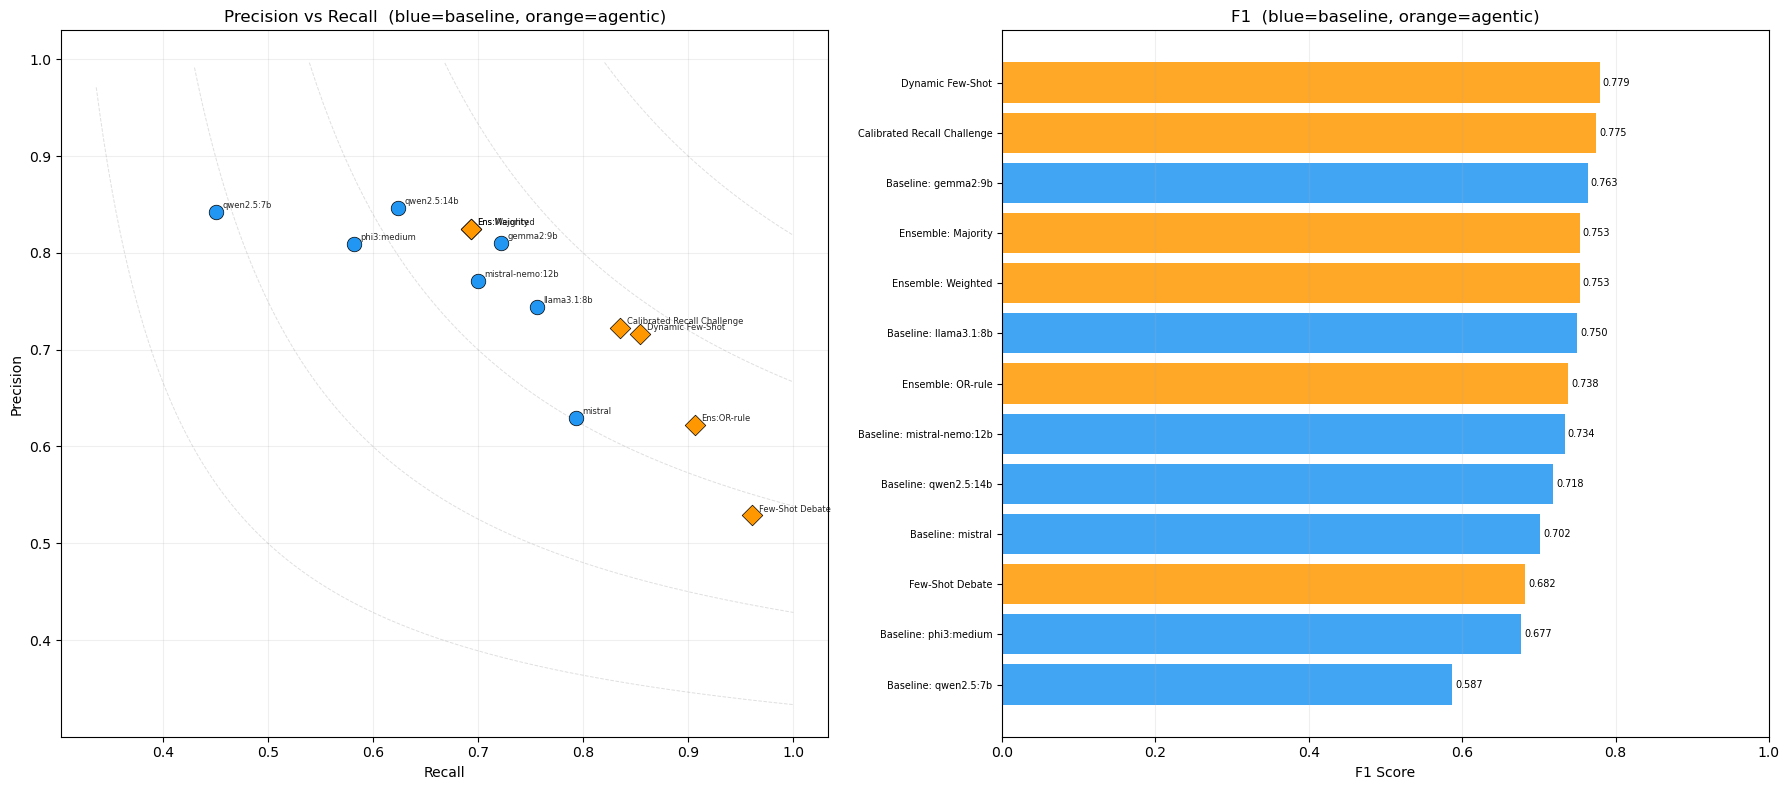

✓ Chart saved.


In [8]:
# =============================================================================
# Phase 4 — Comparison table + visualisation
# =============================================================================
import matplotlib.pyplot as plt

comparison = {}
for model_name in phase1_metrics:
    comparison[f'Baseline: {model_name}'] = phase1_metrics[model_name]
comparison.update(agentic_results)

comp_df = (pd.DataFrame(comparison).T
           .sort_values('f1', ascending=False))

print("\n" + "=" * 80)
print("FULL COMPARISON  (sorted by F1)")
print("=" * 80)
print(f"Eval sample: {len(eval_sample):,} records  "
      f"({(eval_sample['label']==1).sum()} INC / {(eval_sample['label']==0).sum()} EXC)\n")
print(comp_df[['acc', 'prec', 'rec', 'f1', 'time_min']].round(3).to_string())

ts = datetime.now().strftime('%Y%m%d_%H%M%S')
comp_df.to_csv(RESULTS_DIR / f'full_comparison_{ts}.csv')
print(f"\n\u2713 Saved to full_comparison_{ts}.csv")

# ─── Visualisation ───
fig, axes = plt.subplots(1, 2, figsize=(18, max(8, len(comp_df) * 0.45)))

plot_df = comp_df.sort_values('f1', ascending=True)

# Left: Precision vs Recall scatter
for name, row in plot_df.iterrows():
    c = '#FF9800' if 'Baseline' not in name else '#2196F3'
    mk = 'D' if 'Baseline' not in name else 'o'
    axes[0].scatter(row['rec'], row['prec'], s=110, c=c, marker=mk,
                    edgecolors='black', linewidths=0.5, zorder=3)
    short = name.replace('Baseline: ', '').replace('Ensemble: ', 'Ens:')
    axes[0].annotate(short, (row['rec'] + 0.006, row['prec'] + 0.004),
                     fontsize=6, alpha=0.85)

for f1v in [0.5, 0.6, 0.7, 0.8, 0.9]:
    r = np.linspace(max(f1v / 2, 0.01), 1, 200)
    p = (f1v * r) / (2 * r - f1v)
    ok = (p > 0) & (p <= 1)
    axes[0].plot(r[ok], p[ok], '--', color='gray', alpha=0.25, lw=0.7)
axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision')
axes[0].set_title('Precision vs Recall  (blue=baseline, orange=agentic)')
axes[0].grid(alpha=0.2)

# Right: F1 bar chart
colors = ['#FF9800' if 'Baseline' not in n else '#2196F3' for n in plot_df.index]
bars = axes[1].barh(range(len(plot_df)), plot_df['f1'], color=colors, alpha=0.85)
axes[1].set_yticks(range(len(plot_df)))
axes[1].set_yticklabels(plot_df.index, fontsize=7)
for bar, val in zip(bars, plot_df['f1']):
    axes[1].text(val + 0.004, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=7)
axes[1].set_xlabel('F1 Score')
axes[1].set_title('F1  (blue=baseline, orange=agentic)')
axes[1].set_xlim(0, 1.0); axes[1].grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'unified_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\u2713 Chart saved.")

In [10]:
# =============================================================================
# Phase 4 — Summary
# =============================================================================
baseline_name = diagnosis['best_model']
baseline_m    = phase1_metrics[baseline_name]

agentic_ranking = sorted(agentic_results.items(), key=lambda x: x[1]['f1'], reverse=True)
best_ag_name, best_ag_m = agentic_ranking[0]

print("=" * 80)
print("UNIFIED PIPELINE SUMMARY")
print("=" * 80)
n_inc = (eval_sample['label']==1).sum()
n_exc = (eval_sample['label']==0).sum()
ratio = n_exc / n_inc if n_inc > 0 else 0
print(f"\n  Eval set:      {len(eval_sample):,} records "
      f"({n_inc} INC / {n_exc} EXC, "
      f"{ratio:.1f}:1 ratio)")
print(f"  Models:        {len(MODELS)}")
print(f"  Strategies:    {len(diagnosis['strategies'])} (auto-selected)")
print(f"  Bottleneck:    {diagnosis['bottleneck'].upper()}")

print(f"\n  Best baseline: {baseline_name}")
print(f"    Acc={baseline_m['acc']:.3f}  Prec={baseline_m['prec']:.3f}  "
      f"Rec={baseline_m['rec']:.3f}  F1={baseline_m['f1']:.3f}")

print(f"\n  Best agentic:  {best_ag_name}")
print(f"    Acc={best_ag_m['acc']:.3f}  Prec={best_ag_m['prec']:.3f}  "
      f"Rec={best_ag_m['rec']:.3f}  F1={best_ag_m['f1']:.3f}")

delta_f1  = best_ag_m['f1']  - baseline_m['f1']
delta_rec = best_ag_m['rec'] - baseline_m['rec']
if delta_f1 > 0:
    print(f"\n  \u2713 Agentic improvement: +{delta_f1:.3f} F1, +{delta_rec:.3f} recall")
else:
    print(f"\n  \u25b3 No F1 improvement ({delta_f1:+.3f})")

print(f"\n  {'Approach':<35} {'F1':>6} {'\u0394F1':>7} {'Rec':>6} {'\u0394Rec':>7} {'Prec':>6}")
print(f"  {'-'*35} {'-'*6} {'-'*7} {'-'*6} {'-'*7} {'-'*6}")
for name, m in agentic_ranking:
    df1 = m['f1'] - baseline_m['f1']
    dr  = m['rec'] - baseline_m['rec']
    sf  = '+' if df1 >= 0 else ''
    sr  = '+' if dr  >= 0 else ''
    print(f"  {name:<35} {m['f1']:>6.3f} {sf}{df1:>6.3f} "
          f"{m['rec']:>6.3f} {sr}{dr:>6.3f} {m['prec']:>6.3f}")

# Highest recall
best_rec = max(agentic_ranking, key=lambda x: x[1]['rec'])
print(f"\n  Highest recall: {best_rec[0]} (Rec={best_rec[1]['rec']:.3f}, F1={best_rec[1]['f1']:.3f})")

UNIFIED PIPELINE SUMMARY

  Eval set:      5,721 records (899 INC / 4822 EXC, 5.4:1 ratio)
  Models:        7
  Strategies:    4 (auto-selected)
  Bottleneck:    RECALL

  Best baseline: gemma2:9b
    Acc=0.930  Prec=0.810  Rec=0.722  F1=0.763

  Best agentic:  Dynamic Few-Shot
    Acc=0.924  Prec=0.716  Rec=0.854  F1=0.779

  ✓ Agentic improvement: +0.016 F1, +0.132 recall

  Approach                                F1     ΔF1    Rec    ΔRec   Prec
  ----------------------------------- ------ ------- ------ ------- ------
  Dynamic Few-Shot                     0.779 + 0.016  0.854 + 0.132  0.716
  Calibrated Recall Challenge          0.775 + 0.011  0.835 + 0.114  0.722
  Ensemble: Majority                   0.753 -0.010  0.693 -0.029  0.825
  Ensemble: Weighted                   0.753 -0.010  0.693 -0.029  0.825
  Ensemble: OR-rule                    0.738 -0.026  0.907 + 0.185  0.622
  Few-Shot Debate                      0.682 -0.081  0.961 + 0.239  0.529

  Highest recall: Few-Shot 